In [1]:
%matplotlib notebook

from rlsm.datasets import load_lawyers
from rlsm import ReciprocityLSM

In [2]:
Y, features = load_lawyers()

In [3]:
Y.sum()

892.0

In [14]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|████████████████████████████████████████████████████████████| 7500/7500 [00:57<00:00, 130.68it/s, 63 steps of size 5.58e-02. acc. prob=0.83]


In [5]:
model.print_summary()

AUC: 0.932, WAIC: 2983.373

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
   dist_coef      0.15      0.14      0.15     -0.12      0.41   1669.06      1.00
       r_var      1.64      0.38      1.59      0.94      2.38   1223.15      1.00
  recip_coef      0.46      0.36      0.45     -0.21      1.19   1676.02      1.00
       s_var      2.78      0.64      2.71      1.64      4.04   1050.50      1.00
     sr_corr     -0.40      0.17     -0.40     -0.76     -0.09    748.35      1.00
       z_var      6.63      1.08      6.54      4.68      8.81   1594.69      1.00

Number of divergences: 23


<IPython.core.display.Javascript object>


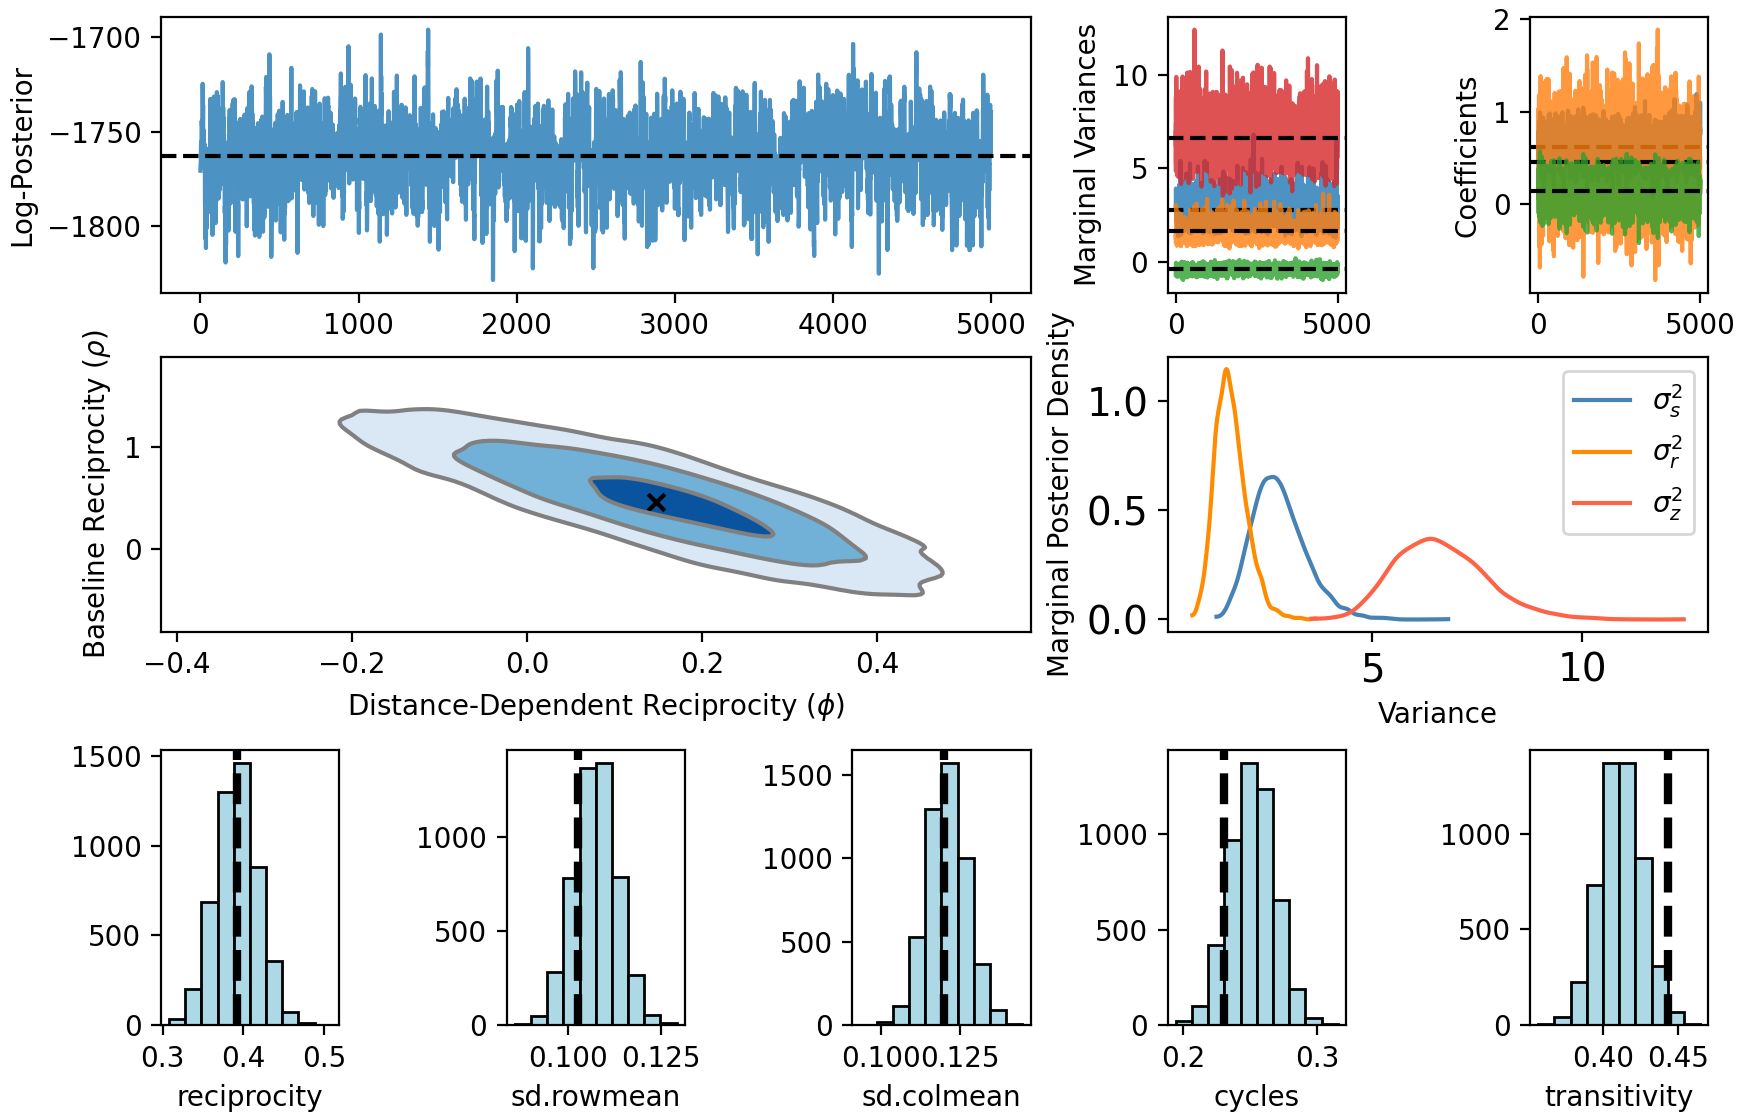

{'A': <Axes: label='A', ylabel='Log-Posterior'>,
 'B': <Axes: label='B', ylabel='Marginal Variances'>,
 'C': <Axes: label='C', ylabel='Coefficients'>,
 'D': <Axes: label='D', xlabel='Distance-Dependent Reciprocity ($\\phi$)', ylabel='Baseline Reciprocity ($\\rho$)'>,
 'E': <Axes: label='E', xlabel='Variance', ylabel='Marginal Posterior Density'>,
 'F': <Axes: label='F', xlabel='reciprocity'>,
 'G': <Axes: label='G', xlabel='sd.rowmean'>,
 'H': <Axes: label='H', xlabel='sd.colmean'>,
 'I': <Axes: label='I', xlabel='cycles'>,
 'J': <Axes: label='J', xlabel='transitivity'>}

In [6]:
model.plot()

<IPython.core.display.Javascript object>


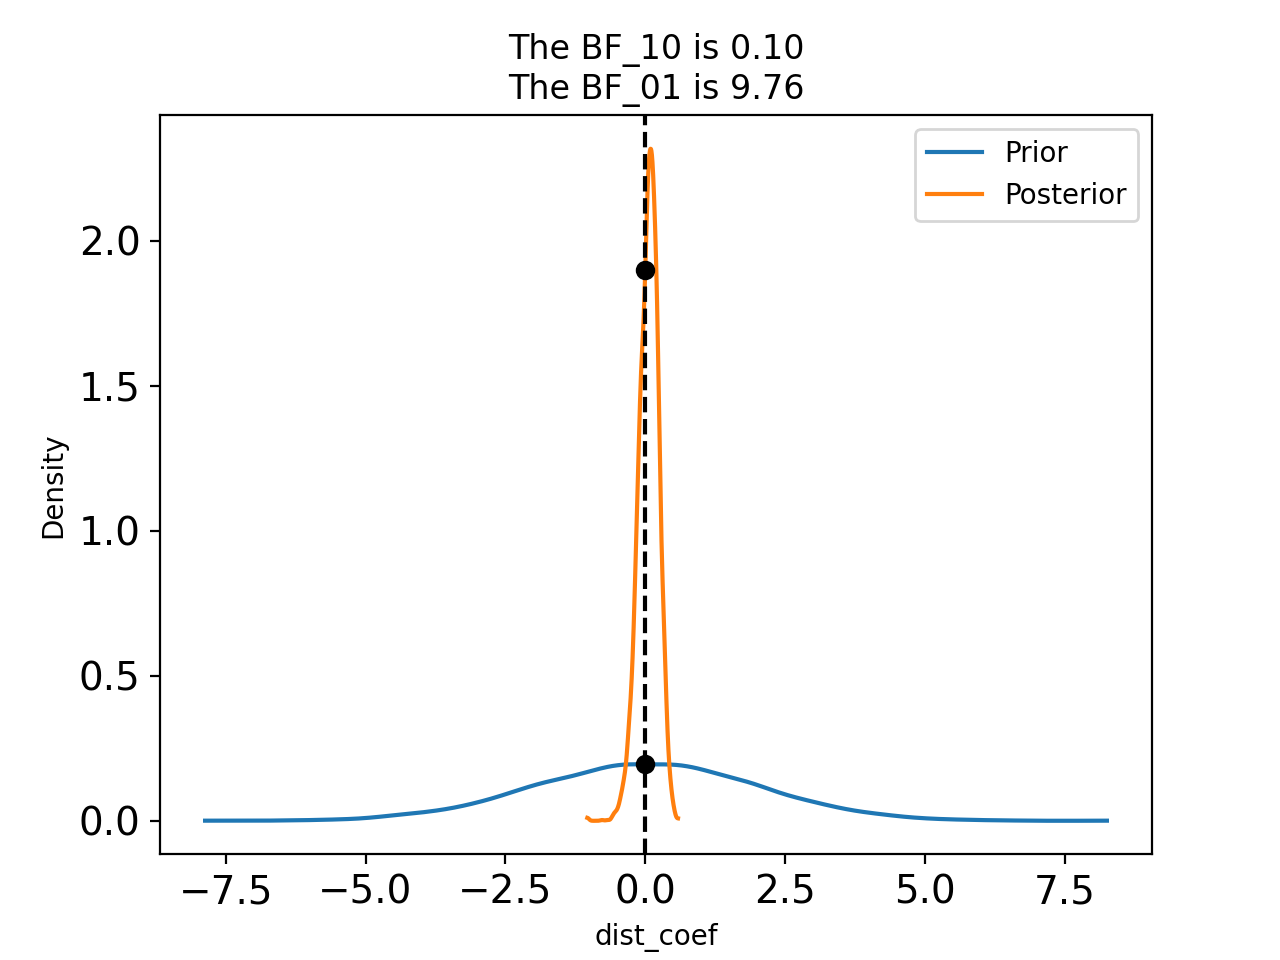

({'BF10': 0.102436157659903, 'BF01': 9.762177954000261},
 <Axes: title={'center': 'The BF_10 is 0.10\nThe BF_01 is 9.76'}, xlabel='dist_coef', ylabel='Density'>)

In [10]:
model.bayes_factor()

<IPython.core.display.Javascript object>


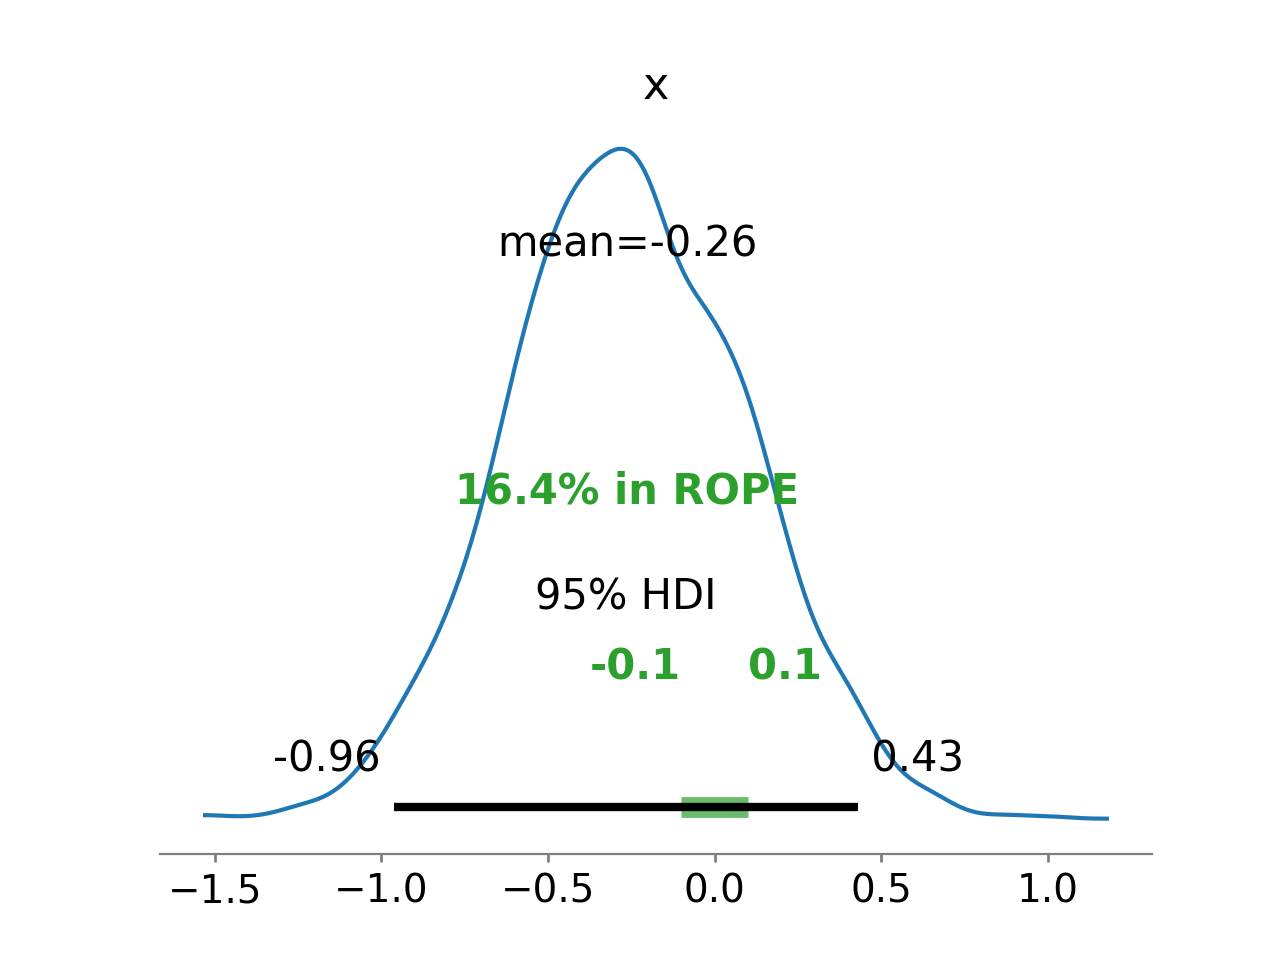

<Axes: title={'center': 'x'}>

In [13]:
import arviz as az

az.plot_posterior(model.samples_['recip_coef'], rope=[-0.1, 0.1], hdi_prob=0.95)

<IPython.core.display.Javascript object>


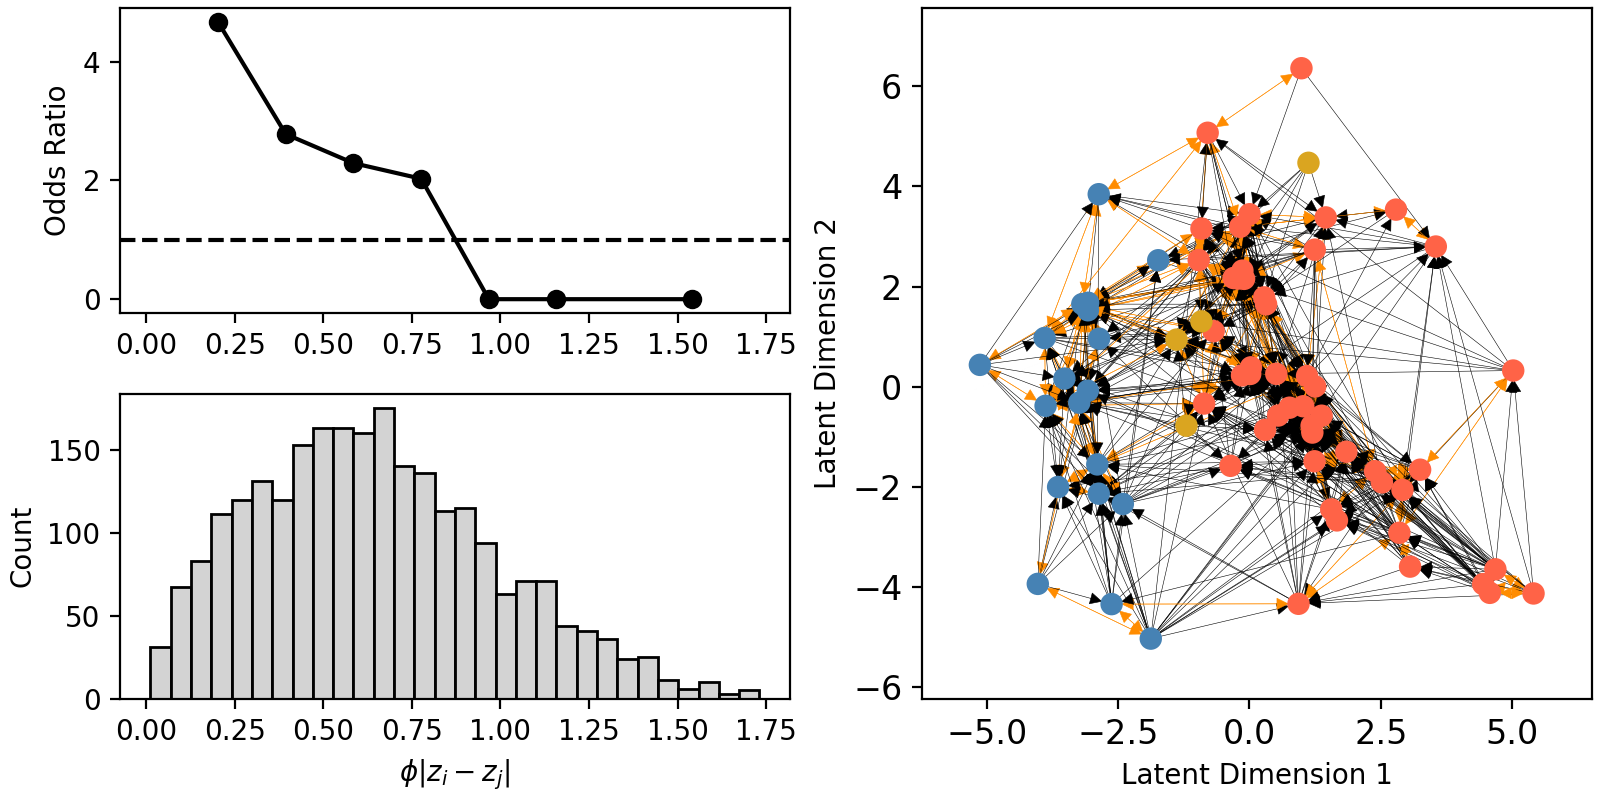

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_15404/1317391714.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [7]:
import networkx as nx

from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')#.histplot(d, axes=ax[0])
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].axhline(1., color='k', linestyle='--')
#ax[0].axvline(model.recip_coef_, linestyle=':', color='gray', lw=2)
ax['A'].set_ylabel('Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

colors = np.asarray(["tomato", "steelblue", "goldenrod"])
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'black' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=colors[features['office'].values - 1],
                 edge_color=ecolor, width=0.2, with_labels=False,
                 node_size=50, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

<IPython.core.display.Javascript object>


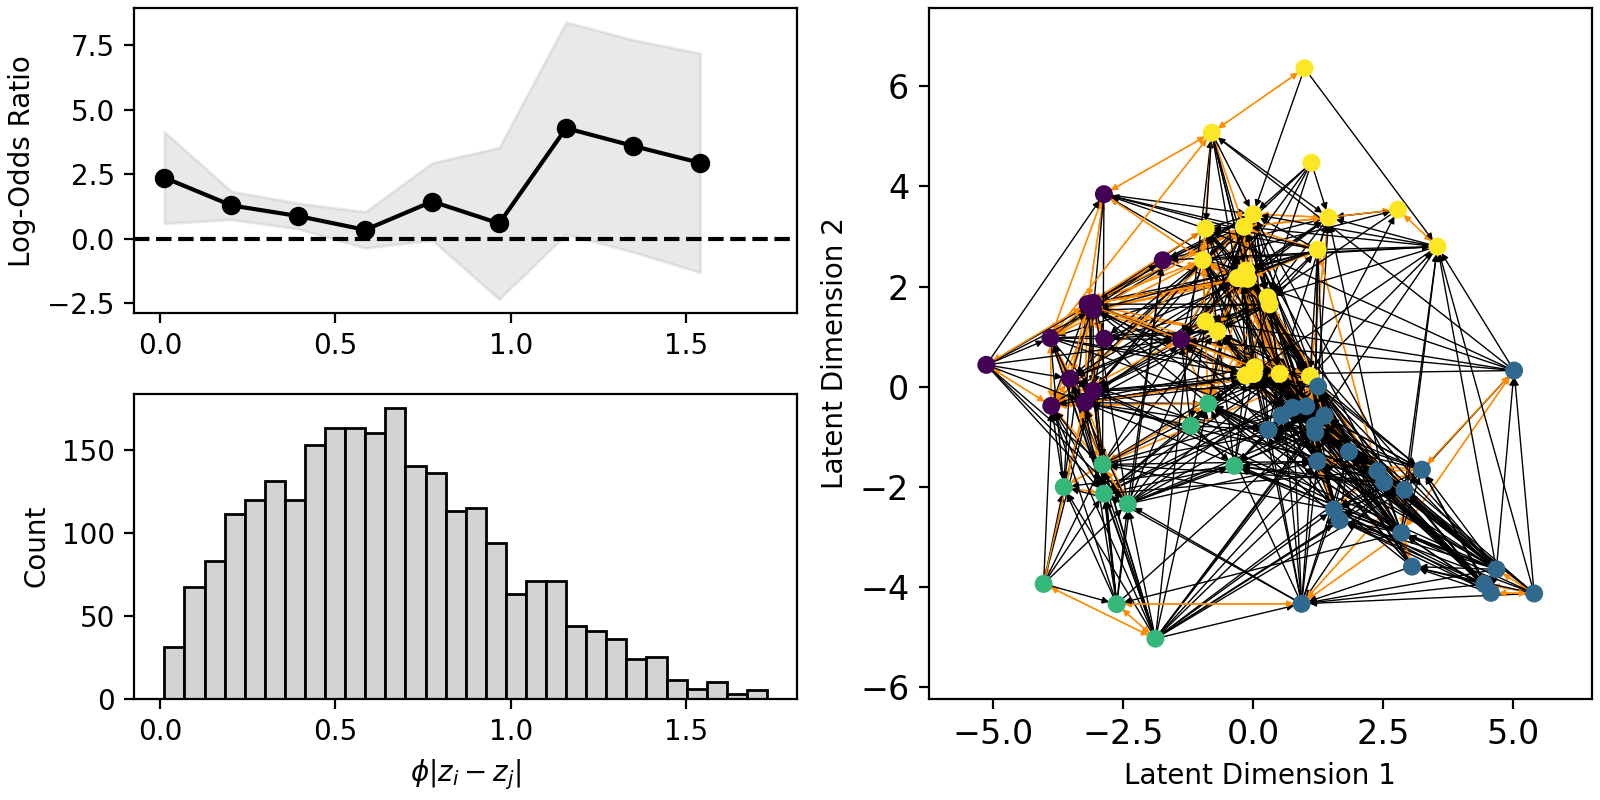

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_15404/1908897797.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


[35.5 25.5  1.5 11.5]
[ 82.5 125.5  20.5 113.5]
[ 45.5 142.5  32.5 244.5]
[ 11.5  98.5  34.5 415.5]
[  2.5  35.5   6.5 390.5]
[  0.5  14.5   5.5 288.5]
[  0.5   2.5   0.5 182.5]
[ 0.5  2.5  0.5 91.5]
[ 0.5  0.5  1.5 28.5]


In [15]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 20))
dist = []
diff = np.diff(qs)[0] * 0.5
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
    tots = a.sum(axis=0) 
    tots += 0.5
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    print(tots)
    if np.prod(tots) > 0:#tots[1] * tots[2] > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(qs[i])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

In [51]:
qs

array([0.00403326, 0.04010695, 0.06304912, 0.0800006 , 0.09489587,
       0.10808353, 0.12189843, 0.13683618, 0.15119044, 0.16720046,
       0.17893946, 0.19161062, 0.20468066, 0.21535306, 0.22841777,
       0.24521441, 0.2605965 , 0.2837368 , 0.31646456, 0.41735899])

In [33]:
ses

array([1.2911544 , 0.61835104, 0.56266016, 0.6984388 , 0.79674774,
       2.0537648 ], dtype=float32)

In [30]:
res

array([ 0.24550043,  0.87296563,  0.06357285,  0.10047055,  0.74688786,
       -0.10032275,        -inf,        -inf], dtype=float32)

In [9]:
model = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|████████████████████████████████████████████████████████████| 7500/7500 [00:44<00:00, 167.67it/s, 63 steps of size 7.52e-02. acc. prob=0.83]


In [10]:
model.print_summary()

AUC: 0.933, WAIC: 2972.691

                mean       std    median      2.5%     97.5%     n_eff     r_hat
     r_var      1.53      0.39      1.48      0.84      2.28   1364.53      1.00
     s_var      2.72      0.63      2.64      1.63      3.98   1304.55      1.00
   sr_corr     -0.15      0.16     -0.15     -0.45      0.16   1242.04      1.00
     z_var      7.43      1.17      7.32      5.21      9.75   1465.83      1.00

Number of divergences: 22


In [11]:
model = ReciprocityLSM(n_features=2, reciprocity_type='constant', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|█████████████████████████████████████████████████████████████| 7500/7500 [01:16<00:00, 98.25it/s, 63 steps of size 4.36e-02. acc. prob=0.88]


In [12]:
model.print_summary()

AUC: 0.933, WAIC: 2979.331

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
       r_var      1.60      0.38      1.56      0.91      2.36   1519.81      1.00
  recip_coef      0.80      0.19      0.80      0.43      1.17   3612.93      1.00
       s_var      2.81      0.64      2.74      1.71      4.16   1173.22      1.00
     sr_corr     -0.40      0.18     -0.39     -0.76     -0.06   1020.74      1.00
       z_var      6.38      1.09      6.25      4.37      8.61   1026.84      1.00

Number of divergences: 49


<IPython.core.display.Javascript object>


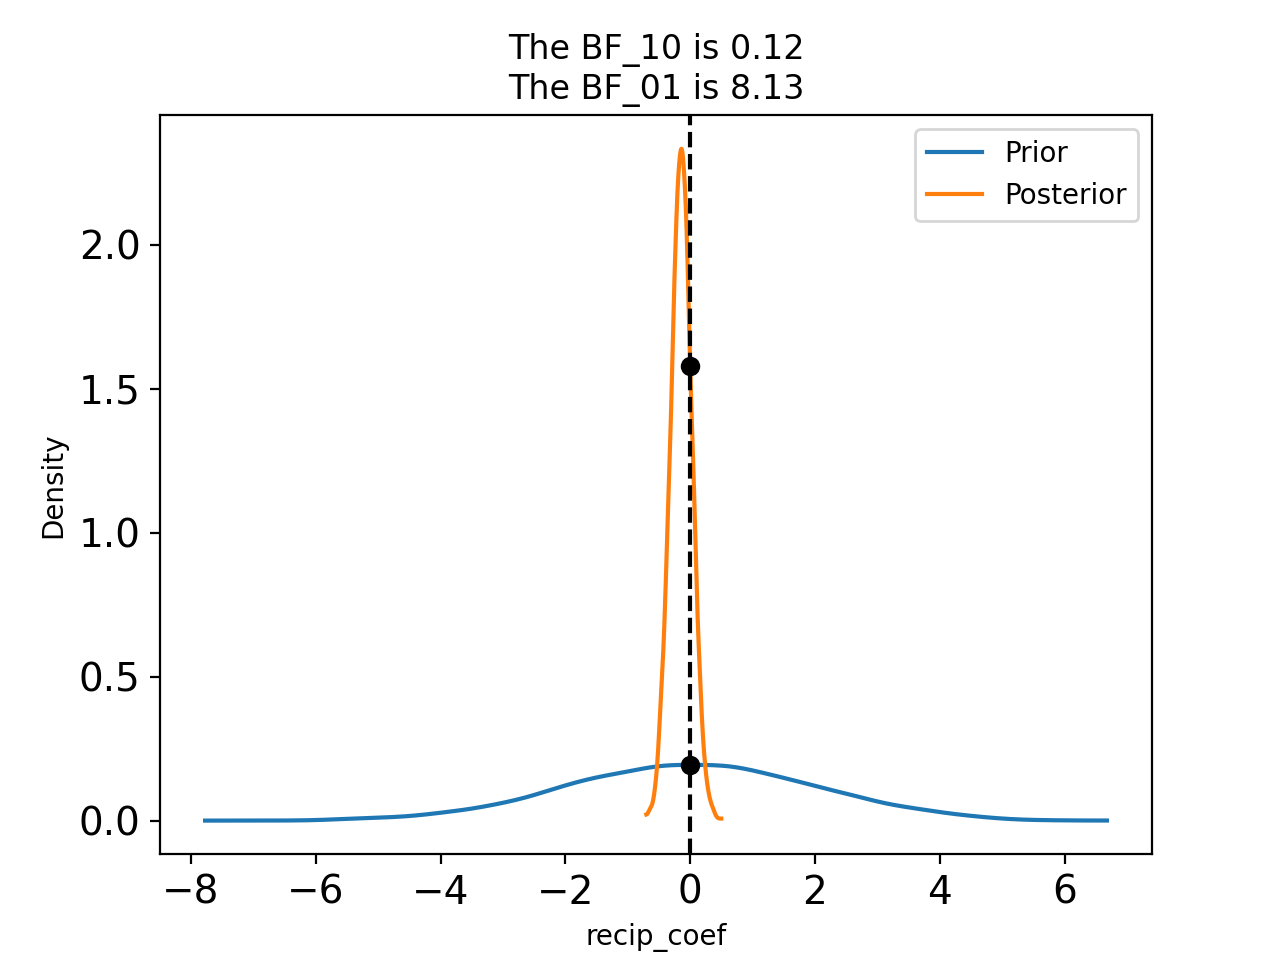

({'BF10': 0.12299238770221468, 'BF01': 8.130584491303386},
 <Axes: title={'center': 'The BF_10 is 0.12\nThe BF_01 is 8.13'}, xlabel='recip_coef', ylabel='Density'>)

In [5]:
model.bayes_factor()